## This notebook handls the emg-dataset found on kaggle

link: https://www.kaggle.com/code/gabo515/emg-hand-gesture-analysis

In [955]:
import pandas as pd 
import numpy as np

data = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_and_labeled_dataset(easiest to work with)/emg_all_features_labeled.csv")

data.shape

(6822, 81)

In [956]:
x = data.iloc[:,:80].copy()
y = data.iloc[:,80].copy()
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([1039, 1017, 1045, 1084, 1016,  726,  895], dtype=int64))

In [957]:
gestures = ["index_finger", "middle_finger", "ring_finger", "little_finger", "thumb", "rest", "victory_gesture"]
for ges in gestures: 
    print(ges + ":", end="")
    print(pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/{}/minimum.csv".format(ges)).to_numpy().shape)

index_finger:(1039, 8)
middle_finger:(1016, 8)
ring_finger:(1044, 8)
little_finger:(1083, 8)
thumb:(1015, 8)
rest:(725, 8)
victory_gesture:(894, 8)


In [958]:
x = x.to_numpy()

In [959]:
raw = pd.read_csv("Electro-Myography-EMG-Dataset/raw_emg_data_unprocessed/index_finger_motion_raw.csv").to_numpy()

In [960]:
raw_electrod = pd.read_csv("Electro-Myography-EMG-Dataset/raw_emg_data_unprocessed/index_finger_motion_raw.csv").to_numpy()[:, 0]
raw_electrod.shape

(223793,)

In [961]:
from numpy.lib.stride_tricks import sliding_window_view

def find_sequence(ary, seq): 
    length = len(seq)
    idx = np.nonzero(np.all(sliding_window_view(ary, window_shape=length)==seq, axis=1))[0]
    return np.array([np.arange(i, i+length) for i in idx])

find_sequence(np.array([1, 2, 3, 4, 4, 2, 3]), np.array([1, 2, 3]))

array([[0, 1, 2]], dtype=int64)

In [962]:
crop_electrod = pd.read_csv("Electro-Myography-EMG-Dataset/raw_emg_data_cropped_and_arranged/index_finger/electrode_1.csv").to_numpy()
find_sequence(raw_electrod, crop_electrod[3,:])


array([[1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276,
        1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287,
        1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298,
        1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309,
        1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320,
        1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331,
        1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342,
        1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353,
        1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364,
        1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375,
        1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386,
        1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397,
        1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408,
        1409, 1410, 1411, 1412, 1413, 

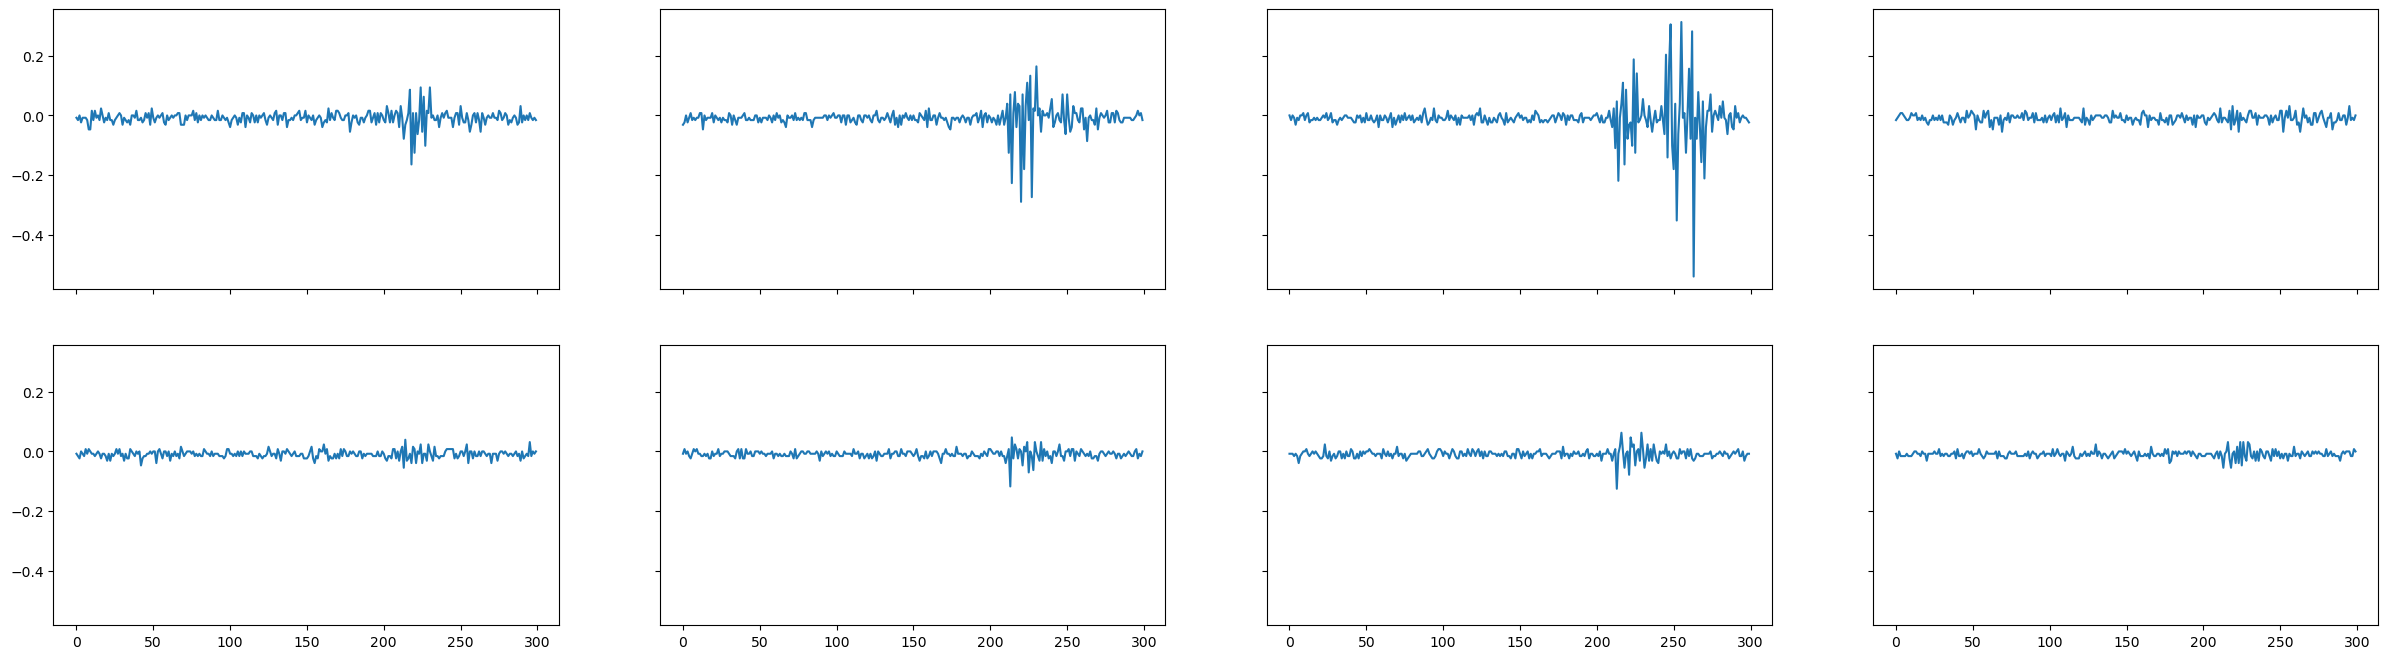

In [963]:
import matplotlib.pyplot as plt 

region = 200, 500
fig, ax = plt.subplots(2,4, figsize=(30, 8), sharex=True, sharey=True)
j, k = 0, 0
for i, _ in enumerate(raw.T): 
    ax[j][k].plot(raw[region[0]:region[1],i])
    k += 1
    if k >= 4: 
        j += 1
        k = 0

## Burst detection in emg singal and take preceding and following 75 samples 

method: moving average of singal and when exceeding a threshold: classify as burst

In [964]:
raw.shape, crop_electrod.shape

((223793, 8), (726, 150))

In [965]:
for ges in gestures: 
    print(ges + ":", end="")
    print(pd.read_csv("Electro-Myography-EMG-Dataset/raw_emg_data_cropped_and_arranged/{}/electrode_1.csv".format(ges)).to_numpy().shape)

# some gestures seem to have get messed up here! index finger is containing 726 though should contain 1039 etc. 

index_finger:(726, 150)
middle_finger:(710, 150)
ring_finger:(771, 150)
little_finger:(824, 150)
thumb:(783, 150)
rest:(517, 150)
victory_gesture:(241, 150)


(223793, 8)


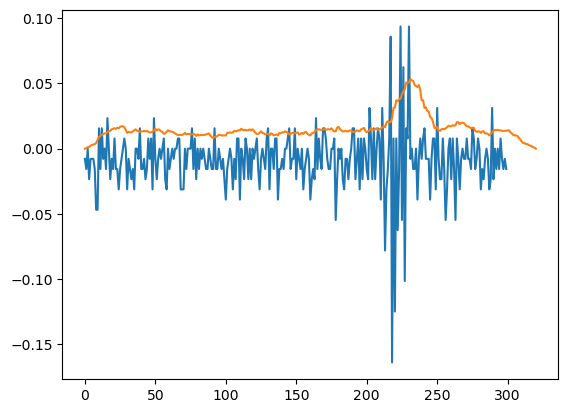

In [966]:
def moving_average(ary, delay=2): 
    """
    input: ary like: rows -> channels, cols -> sample data
    moving average on a given time window with delay as specified, returns array
    """
    # leading and past zeros 
    zeros = np.zeros((delay, ary.shape[1]))
    ary = np.vstack((zeros, np.abs(ary), zeros))
    return np.mean(sliding_window_view(ary, window_shape=(delay, ary.shape[1])), axis=2)[:, 0]
    

channel = 0
print(raw.shape)
plt.plot(raw[region[0]:region[1], channel])
plt.plot(moving_average(raw[region[0]:region[1], channel].reshape(region[1]-region[0], 1), 20))

In [967]:
def get_burst_indices(move_avg_data, threshold):
    return np.where(np.any(move_avg_data > threshold, axis=1))[0]
    
threshold = 0.043
burst_indices = get_burst_indices(moving_average(raw, 20), threshold)
burst_indices

array([   419,    420,    421, ..., 223789, 223790, 223791], dtype=int64)

In [968]:
from more_itertools import pairwise

def cluster_indices(b_idcs, length=100):
    return np.where(np.abs(b_idcs[:-1] - b_idcs[1:]) > length)[0]

def cluster_data(raw_data, ind, length=100, w_size=150):
    # print(raw_data.shape)
    data = []
    for s_idx, e_idx in pairwise(cluster_indices(ind, length)):
        up_lim = int((ind[s_idx+1] + ind[e_idx]) / 2) + int(w_size/2)
        low_lim = up_lim - w_size
        data.append(zz:=raw_data[low_lim:up_lim])
    try: 
        return np.concatenate([d.T for d in data])
    except ValueError: 
        return np.concatenate([d.T for d in data[:-1]]) # throw out last one

print(raw_electrod.shape)
data = cluster_data(raw_electrod.reshape(raw_electrod.shape[0], 1), burst_indices)
data.shape, crop_electrod.shape, raw[:,0].shape

(223793,)


((516, 150), (726, 150), (223793,))

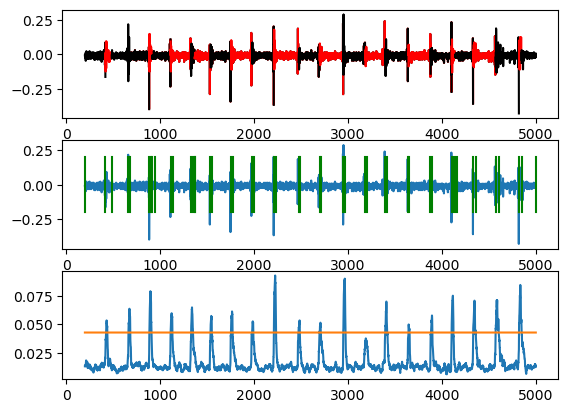

In [969]:
from itertools import cycle

def plt_burst(data, b_idx, cha, x_lim=(200, 5000)):
    idcs = b_idx[(x_lim[0] < b_idx) & (b_idx < x_lim[1])]
    idcs = np.hstack([x_lim[0], idcs[0], idcs[(con:=np.where(idcs[1:] - idcs[:-1] > 5))], idcs[con[0]+1], idcs[-1], x_lim[1]])
    colors = cycle(["k", "r"])
    fig, ax = plt.subplots(3)
    for idx, color in zip(pairwise(idcs), colors):
        ax[0].plot(np.arange(idx[0],idx[1]), data[idx[0]:idx[1], cha], color)
    ax[1].plot(np.arange(x_lim[0], x_lim[1]), data[x_lim[0]:x_lim[1], cha])
    ax[2].plot(np.arange(x_lim[0], x_lim[1]), moving_average(raw, 20)[x_lim[0]:x_lim[1], cha])
    ax[2].plot(np.arange(x_lim[0], x_lim[1]), np.repeat(threshold, x_lim[1] - x_lim[0]))
    for idx in idcs: 
        ax[1].plot([idx, idx], [-0.2, 0.2], color="green")
    

plt_burst(raw, burst_indices, 0)

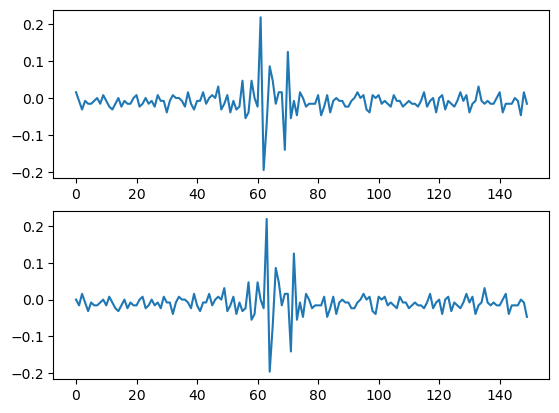

In [970]:
z = 0
fig, ax = plt.subplots(2,1)
ax[0].plot(crop_electrod[z,:])
ax[1].plot(data[z,:])

In [971]:
feat_data_min = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/minimum.csv").to_numpy()
feat_data_min.shape

(1039, 8)

In [972]:
feat_data_min[531, 0]

-0.10938

In [973]:
np.min(crop_electrod[544, :]) # missing values in extracted features 

-0.10938

### Extract features in data


In [974]:
# maximum
feat_data_max =  pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/maximum.csv").to_numpy()
def maximum(ary): 
    return np.max(ary, axis=1)

maximum(data)[0], feat_data_max[0, 0]

(0.21875, 0.21875)

In [975]:
# minimum
def minimum(ary):
    return np.min(ary, axis=1)

minimum(data)[0], feat_data_min[0, 0]

(-0.19531, -0.19531)

In [976]:
# average amplitude change (AAC)
feat_data_avamp = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/average_amplitude_change.csv").to_numpy()
def average_amp(ary):
    return np.mean(np.abs(ary[:, 1:] - ary[:, :-1]), axis=1)

zz = 2
average_amp(data)[zz], feat_data_avamp[zz, 0], average_amp(crop_electrod)[zz]

(0.027947006711409397, 0.074115, 0.028051872483221482)

In [977]:
# mean absolut value
feat_data_mean_abs = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/mean_absolute_value.csv").to_numpy()

def mean_abs_val(ary, **kwargs):
    """ 
    Calculates the mean absolt value, can weighted by setting the weigth value
    Either specify bound, val and other like [[0, 0.25], [0.25, 0.75]]; [0.5, 1]; 0.25
    or a callable func which returns the weighted array with func_params
    """
    try: 
        w = kwargs["func"](ary.shape[0], ary.shape[1])
        print(w)
    except KeyError: 
        assert len(kwargs["bound"]) == len(kwargs["val"])
        w = np.ones(shape=ary.shape) * kwargs["other"]
        for bound, value in zip(kwargs["bound"], kwargs["val"]):
            w[:, int(bound[0]*(ln:=ary.shape[1])): int(bound[1]*ln)] = value
    return np.mean(w*np.abs(ary), axis=1)


def weighted_func(height, width):
    w = []
    for i in range(width):
        if 0.25*width <= i <= 0.75*width: 
            w.append(1)
        elif i < 0.25*width: 
            w.append(4*i / width)
        else:
            w.append(4*(i-width) / width)
    return np.repeat(np.array(w)[np.newaxis, :], height, axis=0)
    

(mean_abs_val(data, bound=[[0.25, 0.75]], val=[1], other=0.5)[1], 
 mean_abs_val(crop_electrod, bound=[[0.25, 0.75]], val=[1], other=0.5)[1], 
 feat_data_mean_abs[1, 0])


(0.01984387333333333, 0.01979179, 0.020696)

In [978]:
# root mean square
feat_data_rms = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/root_mean_square.csv").to_numpy()
def rms(ary):
    return np.sqrt(np.mean(np.square(ary), axis=1))

rms(data)[0], rms(crop_electrod)[0], feat_data_rms[0, 0]

(0.03605067469671453, 0.03607324147141479, 0.036073)

In [979]:
## standard deviation
feat_data_std = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/standard_deviation.csv").to_numpy()
def sta_dev(ary):
    return np.std(ary, axis=1)

zz= 1
sta_dev(data)[zz], sta_dev(crop_electrod)[zz], feat_data_std[zz, 0]



(0.04376581638904005, 0.04383505798452046, 0.043982)

In [980]:
# waveform length 
feat_data_wav_len = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/waveform_length.csv").to_numpy()
def waveform_length(ary):
    return np.sum(np.abs(ary[:, 1:] - ary[:, :-1]), axis= 1)

zz = 2
waveform_length(data)[zz], waveform_length(crop_electrod)[zz], feat_data_wav_len[zz, 0]


(4.164104, 4.179729000000001, 4.1797)

In [981]:
## willison amplitude (WAMP)
feat_data_willi = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/willison_amplitude.csv").to_numpy()

def willison_amp(ary, threshold=0.2):
    return np.count_nonzero(np.abs(ary[:, :-1] - ary[:, 1:])>= threshold, axis=1)

zz = range(20)
willison_amp(data, 0.2)[zz], willison_amp(crop_electrod, 0.2)[zz], feat_data_willi[zz, 0]
    

(array([3, 3, 1, 0, 2, 2, 3, 5, 1, 1, 6, 0, 1, 1, 4, 4, 2, 6, 3, 7],
       dtype=int64),
 array([3, 3, 1, 0, 2, 2, 3, 5, 1, 1, 6, 0, 1, 1, 4, 4, 2, 6, 3, 7],
       dtype=int64),
 array([3, 3, 2, 2, 2, 2, 2, 3, 3, 1, 2, 0, 2, 2, 2, 3, 2, 3, 5, 2],
       dtype=int64))

In [982]:
## zero crossing
feat_data_zerocros = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/zero_crossings.csv").to_numpy()

def zero_crossing(ary):
    return np.count_nonzero(ary[:, :-1] * ary[:, 1:] < 0, axis=1)

zz = 5
zero_crossing(crop_electrod)[zz], feat_data_zerocros[zz, 0]


(52, 52)

In [983]:
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series, plot_bursts

In [984]:
# Settings for the dual threshold algorithm
sig = raw[:, 0]
print(raw.shape)
print(raw.shape[0]/10000)
times = create_times(raw.shape[0]/10000, 10000)
# Detect bursts using dual threshold algorithm
bursting = detect_bursts_dual_threshold(sig, 10000,(0.8, 2.7), min_burst_duration=.001)
idx = np.where(bursting)
idx, cluster_indices(idx[0], 35).shape

(223793, 8)
22.3793


((array([   415,    416,    417, ..., 223490, 223491, 223492], dtype=int64),),
 (890,))

223793
(223793,)


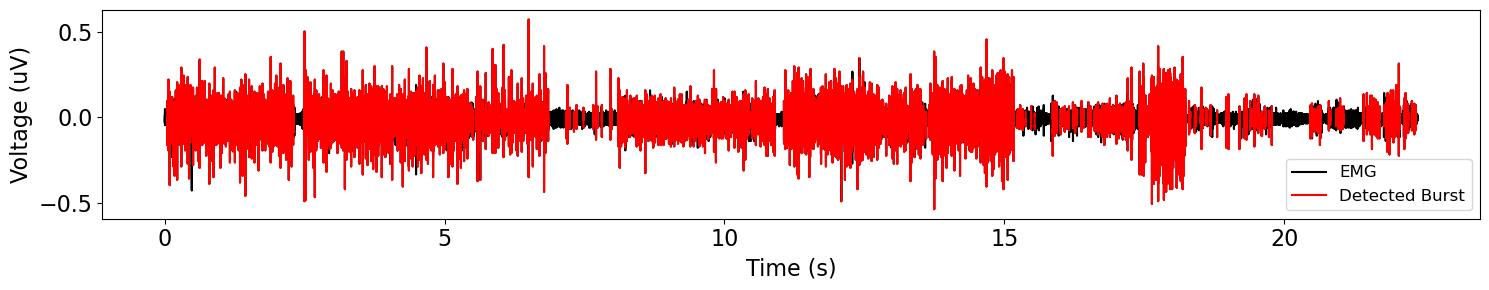

In [985]:
# Plot original signal and burst activity
print(len(times))
print(bursting.shape)
plot_bursts(times, sig, bursting, labels=['EMG', 'Detected Burst'])

In [986]:
compute_burst_stats(bursting, 10000)

{'n_bursts': 2548,
 'duration_mean': 0.0019383830455259026,
 'duration_std': 0.001210710012982763,
 'percent_burst': 22.0695017270424,
 'bursts_per_second': 113.85521441689419}

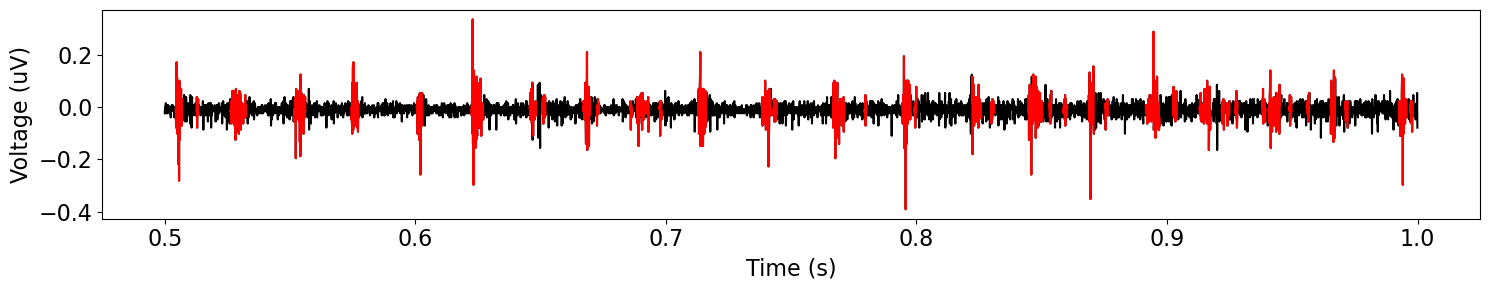

In [987]:
plot_bursts(times[5000:10000], sig[5000:10000], bursting[5000:10000])

In [988]:
feat_data_first_b = pd.read_csv("Electro-Myography-EMG-Dataset/extracted_features_dataset/index_finger/amplitude_first_burst.csv").to_numpy()

0.03125


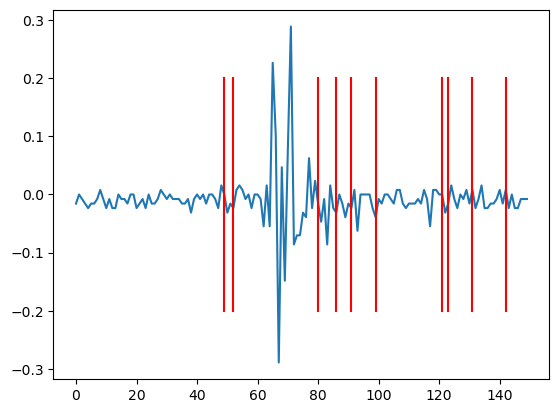

In [989]:
a = crop_electrod[(i:=10)].reshape(1, crop_electrod.shape[1])
val, bound = feat_data_first_b[i, 0], 0.001
print(val)
where = np.where((((amp:=np.abs(a[:, 1:] - a[:, :-1])) > val - bound) & (amp < val + bound)))
amp[where], where

plt.plot(a.T)
for g in where[1]:
    plt.plot((g, g), (-0.2, 0.2), "r")
    

In [990]:
row = feat_data_first_b[0, :]
print(row)

d = []
for i in range(1, 9):
    d.append(pd.read_csv("Electro-Myography-EMG-Dataset/raw_emg_data_cropped_and_arranged/index_finger/electrode_{}.csv".format(i)).to_numpy()[0])
    
d = np.vstack(d)  

amp = np.abs(d[:, 1:] - d[:, :-1])
np.where(((d.T > row - bound) & (d.T < row + bound)).all(axis=1))

[0.046875 0.03125  0.039063 0.039063 0.03125  0.023438 0.023438 0.015625]


(array([], dtype=int64),)

## Do feature extraction on all electrodes
I don't understand what amplitude first burst is

In [991]:
# get raw data 
raw_gest = ["index_finger_motion_raw", "middle_finger_motion_raw", "ring_finger_motion_raw", "little_finger_motion_raw",
            "thumb_motion_raw", "rest_finger_motion_raw", "victory_gesture_motion_raw"]

data = []
# iterate over gestures
for gest in raw_gest: 
    print(gest)
    bursting = []
    raw_gest_data = pd.read_csv("Electro-Myography-EMG-Dataset/raw_emg_data_unprocessed/{}.csv".format(gest)).to_numpy()
    # iterate over electodes
    bursting = []
    for i in range(raw_gest_data.shape[1]):
        # detect bursts in every electrode
        bursting.append(detect_bursts_dual_threshold(raw_gest_data[:,i], 10000, (2.5, 2.7), min_burst_duration=.001))
    # no matter on which electrode the burst is detected --> take all electrodes and stack to array
    b_indc = np.where(np.vstack(bursting).any(axis=0))[0]
    d = []
    # iterate over electrode 
    for elec in range(raw_gest_data.shape[1]):
        # cluster bursting indices and reshape so array shape = (samples, timesteps, electrodes)
        d.append(cluster_data(raw_gest_data[:, elec].reshape(raw_gest_data.shape[0], 1), b_indc, 20))
    d = np.dstack(d)
    print(d.shape)
    data.append(d)
    

index_finger_motion_raw
(749, 150, 8)
middle_finger_motion_raw
(772, 150, 8)
ring_finger_motion_raw
(975, 150, 8)
little_finger_motion_raw
(1040, 150, 8)
thumb_motion_raw
(693, 150, 8)
rest_finger_motion_raw
(126, 150, 8)
victory_gesture_motion_raw
(374, 150, 8)


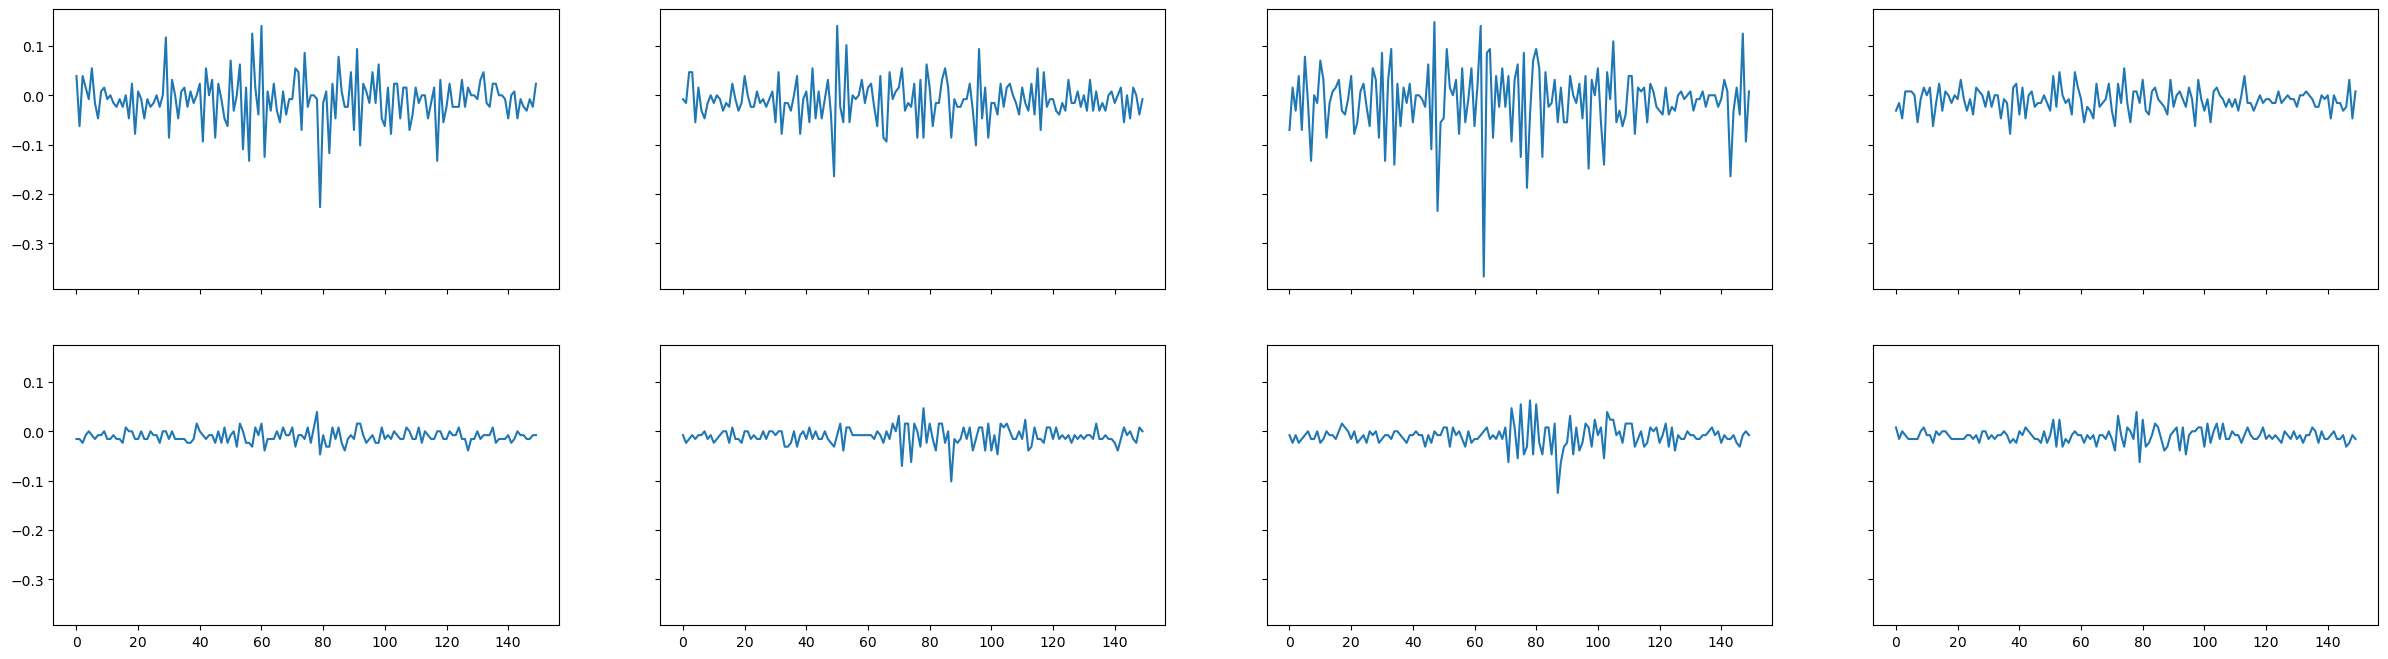

In [992]:
# plot one gesture all electrodes 
fig, axs = plt.subplots(2, 4, figsize=(30, 8), sharex=True, sharey=True)
col, row = 0, 0
for e_idx in range(data[0].shape[2]):
    axs[row][col].plot(data[0][112, :, e_idx])
    col += 1
    if not (e_idx + 1) % 4: 
        row += 1
        col = 0

## Feature extraction 
--> Do feature extraction: average amplitude, maximum, minimum, mean absolut value, root mean square, standard deviation, waveform length, willison amplitude, zero crossings, (amplitude first burst??)

In [993]:
pipeline = {"av_amp": average_amp, 
            "max": maximum, 
            "min": minimum,
            "mean_abs_val": mean_abs_val, 
            "rms": rms, 
            "sta_dev": sta_dev,
            "wave_len": waveform_length, 
            "willi_amp": willison_amp, 
            "zero_cros": zero_crossing}

g = {gest: {name: None for name in pipeline.keys()} for gest in gestures}
for g_data, gest in zip(data, gestures):
    # iterate over pipeline
    for name, handler in pipeline.items():
        ex_feat_data = []
        # iterate over electrodes
        for ele_idx in range(g_data.shape[2]):
            if handler == mean_abs_val: 
                # different call to specify keyword arguments 
                ex_feat_data = handler(g_data, bound=[[0.25, 0.75]], val=[1], other=0.5)
            else:
                ex_feat_data = handler(g_data)
        g[gest][name] = ex_feat_data
                
        
g["index_finger"]["av_amp"].shape

(749, 8)

In [994]:
# get independant and dependant variables 
x = []
y = []
for i, gest in enumerate(g.values()):
    x.append(np.hstack([gest[x] for x in pipeline.keys()]))
    y.append(np.repeat(np.array([i]).reshape(1, 1), len(x[-1]), axis=0))

x = np.vstack(x)
y = np.vstack(y)
x.shape, np.unique(y, return_counts=True)

((4729, 72),
 (array([0, 1, 2, 3, 4, 5, 6]),
  array([ 749,  772,  975, 1040,  693,  126,  374], dtype=int64)))

In [995]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [996]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)
scaler = StandardScaler()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3546, 72), (1183, 72), (3546, 1), (1183, 1))

In [997]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(x_train, np.ravel(y_train))

(y_pred:=model.predict(x_test)), y_test

C:\Users\Finn\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


(array([0, 1, 4, ..., 1, 6, 0]),
 array([[0],
        [3],
        [4],
        ...,
        [1],
        [6],
        [0]]))

In [998]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn 
accuracy_score(y_test, y_pred)

0.8622147083685545

<AxesSubplot:>

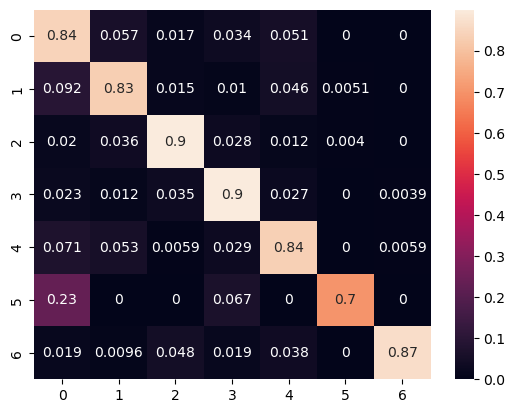

In [999]:
con_mat = confusion_matrix(y_test, y_pred, normalize="true")
sn.heatmap(con_mat, annot=True)

In [1000]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, np.ravel(y_train))
y_pred = model.predict(x_test)

In [1001]:
accuracy_score(y_test, y_pred)

0.7675401521555367

In [1002]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, np.ravel(y_train))
y_pred = model.predict(x_test)

accuracy_score(y_test, y_pred)

0.9163144547759933

In [1004]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(x_train, np.ravel(y_train))
y_pred = model.predict(x_test)

accuracy_score(y_test, y_pred)

0.8664412510566357